In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

**Define image loader to convert input image to the tensor format: (C x H x W)**




`transforms.Resize`: resize the image size to a given size

`transforms.ToTensor()`: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

`tensor.unsqueeze(0)`: Returns a new tensor with a dimension of size one inserted at the 0 position

`tensor.squeeze()`: Returns a tensor with all the dimensions of input of size 1 removed.  Shared storage




In [2]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_size = (512,512) if torch.cuda.is_available() else (128,128)  # use small size if no gpu
loader = transforms.Compose([transforms.Resize(max_size), transforms.ToTensor()])  
def load_image(path):
    img = Image.open(path)
    # add a batch demension to image, which required to fit network's input dimensions
    img = loader(img).unsqueeze(0)  
    # before unsqueeze: (3 * 512 * 512) dimensions
    # after unsqueeze: (1 * 3 * 512 * 512) dimensions
    return img.to(device, torch.float)  # put to GPU


content_img = load_image("/content/dancing.jpg")
style_img = load_image("/content/picasso.jpg")

print(f'Content image dimensions with batch size 1: {content_img.shape}')
print(f'Style image dimensions with batch size 1: {style_img.shape}')

Content image dimensions with batch size 1: torch.Size([1, 3, 512, 512])
Style image dimensions with batch size 1: torch.Size([1, 3, 512, 512])


Define function to show image

`transforms.ToPILImage() `: Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape H x W x C to a PIL Image while preserving the value range.

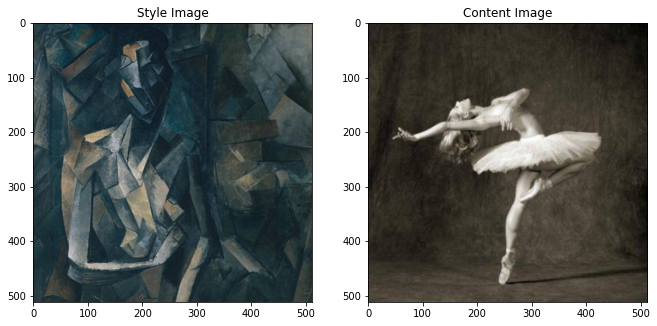

In [3]:
unloader = transforms.ToPILImage() 
def show_image(tensor, title=None):
    image = tensor.cpu().clone()  # use clone to return a copy of tensor
    # now shape: 1 * 3 * 512 * 512
    image = image.squeeze(0)      # remove the batch dimension to make the image 3-dimensions
    # now shape: 3 * 512 * 512
    image = unloader(image)
    # now shape: 512 * 512 * 3, 3 represent RGB channels
    plt.imshow(image)
    if title is not None: plt.title(title)
    # plt.pause(0.001) # pause a bit so that plots are updated

fig = plt.figure(figsize=(11,11))
plt.subplot(1,2,1)
show_image(style_img, title='Style Image')

plt.subplot(1,2,2)
show_image(content_img, title='Content Image')

**The most important part: defining the content loss and style loss**

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach() # detach from computation graph, not calculate gradient for it

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(x):
    # B is batch size = 1, C is number of feature maps (# channels), H is height, W is width
    B, C, H, W = x.shape  
    # resize input dimensions to matrix F^l in dimension N x M. where N = C, M = H * W
    features = x.view(B * C, H * W)  
    G = torch.mm(features, features.t())  # compute the gram product

    # Normalize the values of the gram matrix by dividing by the number of element in each featur maps
    return G.div(B * C * H * W)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [5]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# get vgg model's parameters only in the Conv layer and freeze the weights
for p in cnn.parameters():
  p.requires_grad = False

In [6]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
             # set ReLu inplace = False because it doesn't work well with ContentLoss and StyleLoss
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    # iterate backward until find the content loss layer or style loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

Examine our model structure

In [7]:
get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

(Sequential(
   (0): Normalization()
   (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_1): StyleLoss()
   (relu_1): ReLU()
   (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_2): StyleLoss()
   (relu_2): ReLU()
   (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_3): StyleLoss()
   (relu_3): ReLU()
   (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (content_loss_4): ContentLoss()
   (style_loss_4): StyleLoss()
   (relu_4): ReLU()
   (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_5): StyleLoss()
 ),
 [StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()],
 [ContentLoss()])

In [8]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('Training..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Experiment on original content image

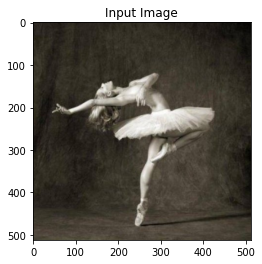

In [9]:
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
show_image(input_img, title='Input Image')

In [10]:
%%time
S_weight = 1000000
C_weight = 1
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,style_weight=S_weight, content_weight=C_weight)

Building the style transfer model..
Training..
run [50]:
Style Loss : 4.174948 Content Loss: 4.176772

run [100]:
Style Loss : 1.191277 Content Loss: 3.065555

run [150]:
Style Loss : 0.734160 Content Loss: 2.677963

run [200]:
Style Loss : 0.497165 Content Loss: 2.511177

run [250]:
Style Loss : 0.357323 Content Loss: 2.418686

run [300]:
Style Loss : 0.271652 Content Loss: 2.363062

CPU times: user 12.7 s, sys: 5.91 s, total: 18.6 s
Wall time: 18.6 s


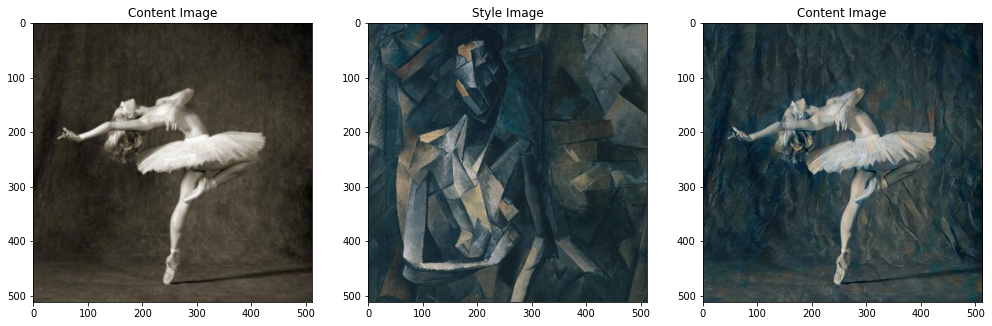

In [11]:
fig = plt.figure(figsize=(17,17))

plt.subplot(1,3,1)
show_image(content_img, title='Content Image')

plt.subplot(1,3,2)
show_image(style_img, title='Style Image')

plt.subplot(1,3,3)
show_image(output, title='Content Image')

Experiment on white noise image

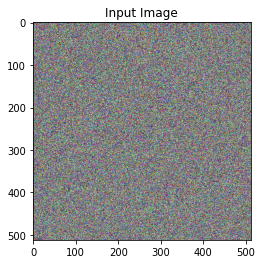

In [12]:
input_img = torch.randn(content_img.data.size(), device=device)
# add the original input image to the figure:
plt.figure()
show_image(input_img, title='Input Image')

In [13]:
%%time
S_weight = 1000000
C_weight = 10
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,style_weight=S_weight, content_weight=C_weight)

Building the style transfer model..
Training..
run [50]:
Style Loss : 87.709358 Content Loss: 61.466667

run [100]:
Style Loss : 26.936333 Content Loss: 36.034920

run [150]:
Style Loss : 6.557140 Content Loss: 27.176493

run [200]:
Style Loss : 3.451260 Content Loss: 23.022480

run [250]:
Style Loss : 2.783845 Content Loss: 21.102474

run [300]:
Style Loss : 2.374538 Content Loss: 20.067863

CPU times: user 12.8 s, sys: 5.91 s, total: 18.7 s
Wall time: 18.7 s


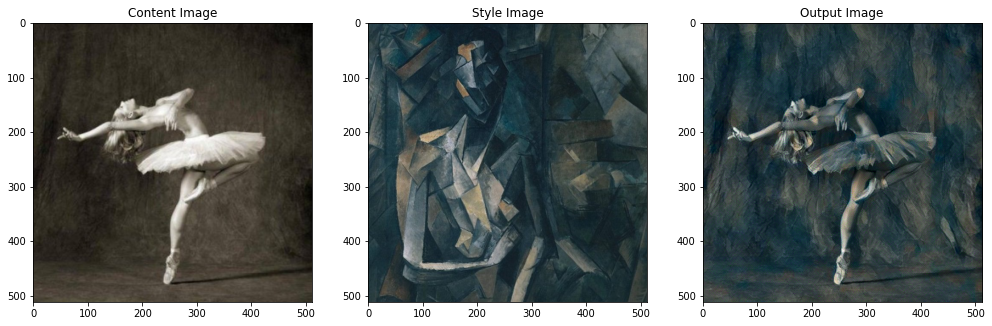

In [14]:
fig = plt.figure(figsize=(17,17))

plt.subplot(1,3,1)
show_image(content_img, title='Content Image')

plt.subplot(1,3,2)
show_image(style_img, title='Style Image')

plt.subplot(1,3,3)
show_image(output, title='Output Image')